In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# On the Docket:

### Stub Strategy (Equal weighted portf)
### Backtesting infrastructure
### Other implementations --> Risk Parity, MV allocation, Weighted MV allocation, mixing previous strategies w/ weights
### Optimization sharpe ratio in levels (window size, strategy, rebalancing rate).

In [32]:
# Fetching Data

data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

np.shape(TEST)

(7800, 6)

## Stub Code

In [33]:
'''
We recommend that you change your train and test split
'''

#TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)


# Change init variables and allocate method in order to change behavior of the allocations.

class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        
        self.running_price_paths = train_data.copy()
        
        self.train_data = train_data.copy()
        
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

    
        ### TODO Implement your code here
        weights = np.array([0,1,-1,0.5,0.1,-0.2])
        
        return weights


def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
print(sharpe)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.title("Capital")
# plt.plot(np.arange(len(TEST)), capital)
# plt.show()

# plt.figure(figsize=(10, 6), dpi=80)
# plt.title("Weights")
# plt.plot(np.arange(len(TEST)), weights)
# plt.legend(TEST.columns)
# plt.show()

0.010993821121174302


## Equal Weighted Portfolio

In [34]:
class Equal_Allocator(Allocator):

    def __init__(self, train_data):
        super().__init__(train_data)
        self.excess_returns = self.running_price_paths.pct_change()

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

    
        ### TODO Implement your code here
        weights = np.ones(6)
        weights = weights / 6
        
        return weights

## Risk-Parity Allocation

### Inverse Vol Matrix --> Fast, somewhat inaccurate, good for daily.

In [35]:
class Inverse_Vol_Alloc(Allocator):
    
    def __init__(self, train_data):
        '''
        Store price history and initialize parameters
        '''
        super().__init__(train_data)
        self.excess_returns = self.running_price_paths.pct_change()
        
        self.lookback_window = 900
        self.current_weights = np.ones(6) / 6

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        new_excess_returns = pd.DataFrame(self.running_price_paths.iloc[-2:].pct_change().dropna())
        self.excess_returns = pd.concat([self.excess_returns, new_excess_returns], ignore_index=True)
    
        ### TODO Implement your code here
        
        cov_matrix = self.excess_returns.iloc[-self.lookback_window:].cov()
        vol = np.sqrt(np.diag(cov_matrix))     # Get standard deviations
        inv_vol = 1 / vol                      # Inverse volatility
        weights = inv_vol / np.sum(inv_vol)   # Normalize

        return weights

### True Risk Parity --> Slow, accurate, good for long-term

Doesn't work lmaoooo

In [36]:
from scipy.optimize import minimize

class Risk_Parity_Alloc(Allocator):
    
    def __init__(self, train_data):
        '''
        Store price history and initialize parameters
        '''
        self.running_price_paths = train_data.copy()

        self.excess_returns = self.running_price_paths.pct_change()
        
        self.train_data = train_data.copy()
        
        self.rebalance_freq = 150    # Rebalance every N ticks
        self.tick_counter = 0
        self.current_weights = np.ones(6) / 6

    def risk_contributions(self, weights, cov_matrix):
        port_var = weights.T @ cov_matrix @ weights
        marginal = cov_matrix @ weights
        total_contrib = weights * marginal
        return total_contrib / np.sqrt(port_var)
    
    def risk_parity_objective(self, weights, cov_matrix):
        rc = self.risk_contributions(weights, cov_matrix)
        target = np.mean(rc)
        return np.sum((rc - target)**2)

    def risk_parity_weights(self, cov_matrix):
        n = cov_matrix.shape[0]
        x0 = np.array([1/n]*n)
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = [(0, 1)] * n  # long-only; change to (-1, 1) for leverage
        
        result = minimize(self.risk_parity_objective, x0, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
        
        return result.x if result.success else x0


    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
    
        ### TODO Implement your code here

        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        new_excess_returns = pd.DataFrame(self.running_price_paths.iloc[-2:].pct_change().dropna())
        self.excess_returns = pd.concat([self.excess_returns, new_excess_returns], ignore_index=True)
        
        if self.tick_counter % self.rebalance_freq != 0:
            self.tick_counter += 1
            return self.current_weights

        cov_matrix = self.excess_returns.cov()

        self.current_weights = self.risk_parity_weights(cov_matrix)

        self.tick_counter += 1

        return self.current_weights


## Mean Variance Allocation

In [66]:
class MV_Alloc():
    def __init__(self, train_data):
        '''
        Store price history and initialize parameters
        '''
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()
        self.lookback_window = 900  # Number of ticks for rolling returns
        self.rebalance_freq = 150    # Rebalance every N ticks
        self.tick_counter = 0
        
        # Initialize weights to equal weights
        self.current_weights = np.array([1/6] * 6)
        
        # Parameters for mean-variance optimization

    def calculate_rolling_er(self, prices, window):
        '''
        Calculate compounded rolling returns over specified window
        '''
        returns = prices.pct_change()
        rolling_rets = (1 + returns).rolling(window).apply(np.prod, raw=True) - 1
        excess_returns = rolling_rets.sub(rolling_rets.mean(axis=1), axis=0).dropna()
        
        return excess_returns
    
    def tangency_portfolio(self, mean_returns, cov_matrix):
        '''
        Compute tangency portfolio weights
        '''
        inverted_cov = np.linalg.pinv(cov_matrix) if np.isclose(np.linalg.det(cov_matrix), 0) else np.linalg.inv(cov_matrix)
        one_vector = np.ones(mean_returns.shape)
        return (inverted_cov @ mean_returns) / (one_vector @ inverted_cov @ mean_returns)
    
    def allocate_portfolio(self, asset_prices):
        self.tick_counter += 1

        # Add new prices directly to NumPy array instead of DataFrame for speed
        if isinstance(self.running_price_paths, pd.DataFrame):
            new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
            self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        else:
            self.running_price_paths = np.vstack([self.running_price_paths, asset_prices])

        # Only rebalance every N ticks
        if self.tick_counter % self.rebalance_freq != 0:
            return self.current_weights

        # Use only most recent window of data
        window = min(self.lookback_window, len(self.running_price_paths))
        prices = self.running_price_paths[-window:]

        # Compute returns (NumPy for speed)
        returns = np.diff(prices, axis=0) / prices[:-1]
        if returns.shape[0] < 2:
            return self.current_weights

        # Expected returns & covariance
        mu = np.mean(returns, axis=0)
        cov = np.cov(returns.T)

        # Tangency portfolio
        try:
            inv_cov = np.linalg.pinv(cov)
            one_vector = np.ones_like(mu)
            allocation = inv_cov @ mu
            allocation /= one_vector @ inv_cov @ mu

            # Target return scaling (optional)
            expected_return = mu @ allocation
            allocation *= 0.0075 / expected_return

            # Constraint to max leverage of 1
            max_leverage = 1.0 / np.max(np.abs(allocation))
            allocation *= max_leverage

            self.current_weights = allocation
        except Exception as e:
            print("Tangency portfolio failed:", e)
            self.current_weights = np.ones(6) / 6

        return self.current_weights

        

## Testing Section

0.013618095802140046


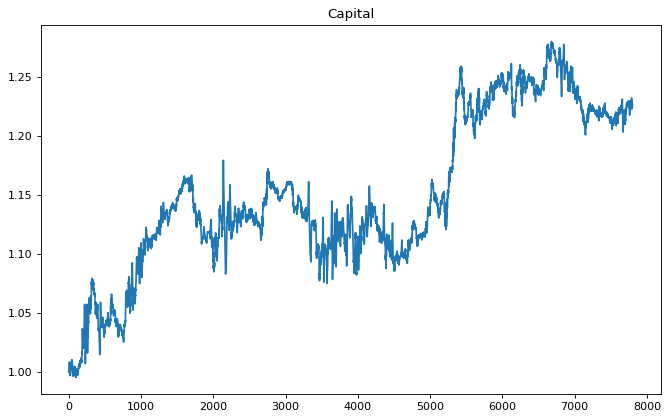

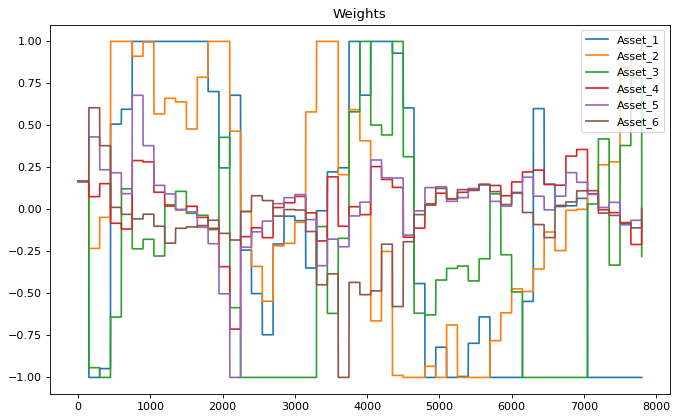

In [67]:
# Backtesting Code

data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = MV_Alloc(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
print(sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()